Lets analyse squid ink.

In [224]:
# Ensure the project root is in PATH.
import sys
sys.path.append("../")
# All imports of our code are relative to the project root.

from backtester.backtester import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing

import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt

In [225]:
market_data_day_0 = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_0.csv"), sep=";")
market_data_day_neg1 = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_-1.csv"), sep=";")
market_data_day_neg2 = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_-2.csv"), sep=";")

trades_day_0 = pd.read_csv(os.path.join("..", "data", "round1", "trades_round_1_day_0.csv"), sep=";")
trades_day_neg1 = pd.read_csv(os.path.join("..", "data", "round1", "trades_round_1_day_-1.csv"), sep=";")
trades_day_neg2 = pd.read_csv(os.path.join("..", "data", "round1", "trades_round_1_day_-2.csv"), sep=";")


# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output

market_data_all3days = concatenate_historical_data([market_data_day_neg2, market_data_day_neg1, market_data_day_0])
trades_all3days = concatenate_historical_data([trades_day_neg2, trades_day_neg1, trades_day_0])

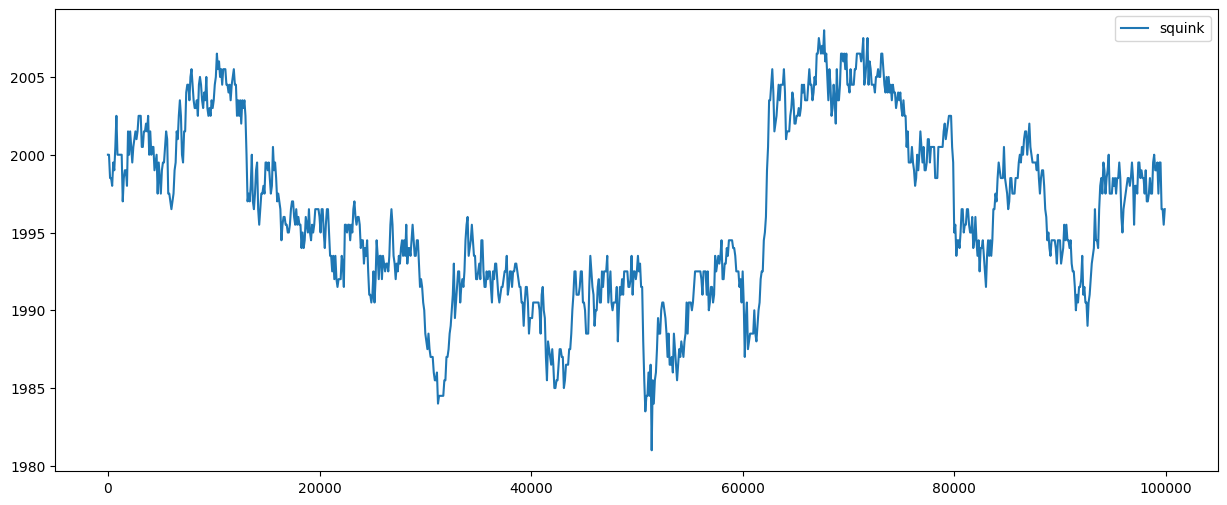

In [226]:
market_data = market_data_all3days
trade_history = trades_all3days

market_data = market_data[market_data['product'] == "SQUID_INK"]
trade_history = trade_history[trade_history['symbol'] == "SQUID_INK"]

market_data = market_data[market_data['timestamp'] < 1e5]


plt.figure(figsize=(15,6))
plt.plot(market_data['timestamp'], market_data['mid_price'], label='squink')
# plt.plot(market_data['timestamp'], market_data_all3days[market_data_all3days['product'] == "KELP"]['mid_price'], label='Kelp')
plt.legend()


We can either market make or we can trade directionally, for the kelp we market maked because it doesn't move much.  

However the squink moves soooo much so I don't think we can market make because then we are just coinflipping on whether it goes up or down.  

Instead I think we have to trade directionally on this.  
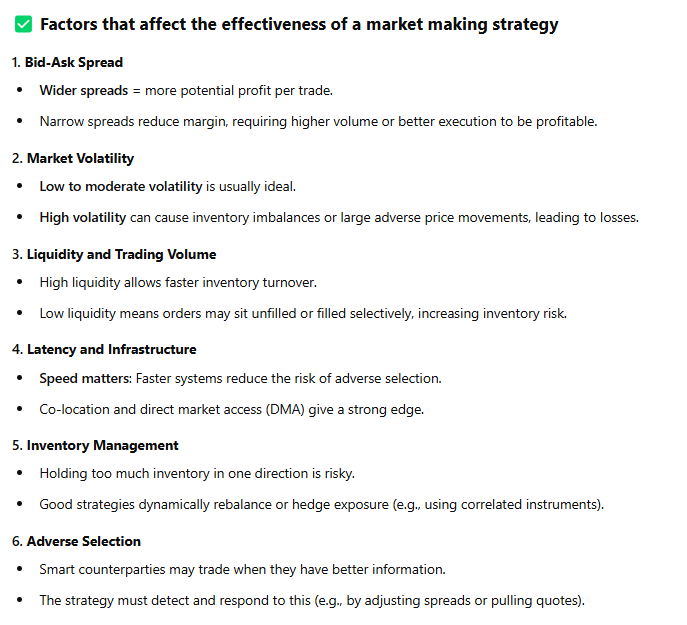

Market is so volatile... lets look at the bid ask spreads regardless.  
Because the price doesn't matter lets just normalise everything to have a constant midprice of 1000. i just wanna see how wide the spreads are.  

C:\Users\raoj6\AppData\Local\Temp\ipykernel_35784\4210436292.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_data['spread'] = market_data['ask_price_1'] - market_data['bid_price_1']


Average spread = 2.6657333333333333, std = 0.865254757603537


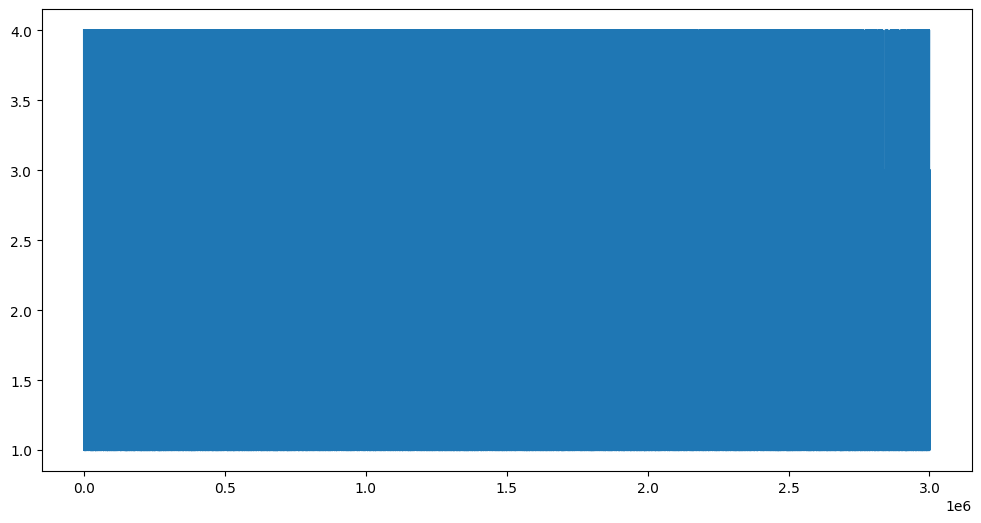

In [227]:
market_data = market_data_all3days[market_data_all3days['product'] == "SQUID_INK"]
# market_data = market_data[market_data['timestamp'] < 1e5]

market_data['spread'] = market_data['ask_price_1'] - market_data['bid_price_1']

plt.figure(figsize=(12,6))
plt.plot(market_data['timestamp'], market_data['spread'])


print(f"Average spread = {np.mean(market_data['spread'])}, std = {np.std(market_data['spread'])}")
 


kelp - Average spread = 2.712, std = 0.88  

squink - Average spread = 2.6657333333333333, std = 0.865254757603537  

So the spread actually is very close to kelp.
This means MM on squid ink not more viable than kelp.  

And its a lot less viable because of how volatile the market is.    

Lets start with something simple. propserity website gives the following hint.  

Squid Ink can be a very volatile product with price having large swings. Making a two-sided market or carrying position can be risky for such an instrument. However, with large swings comes large reversion. Squid Ink prices show more tendency to revert short term swings in price.  

A metric to keep track of the size of deviation/swing from recent average could help in trading profitable positions.  

So possibly something like the moving average and just trading when its away from the mean?  
i.e. doing some mean reversion stuff  





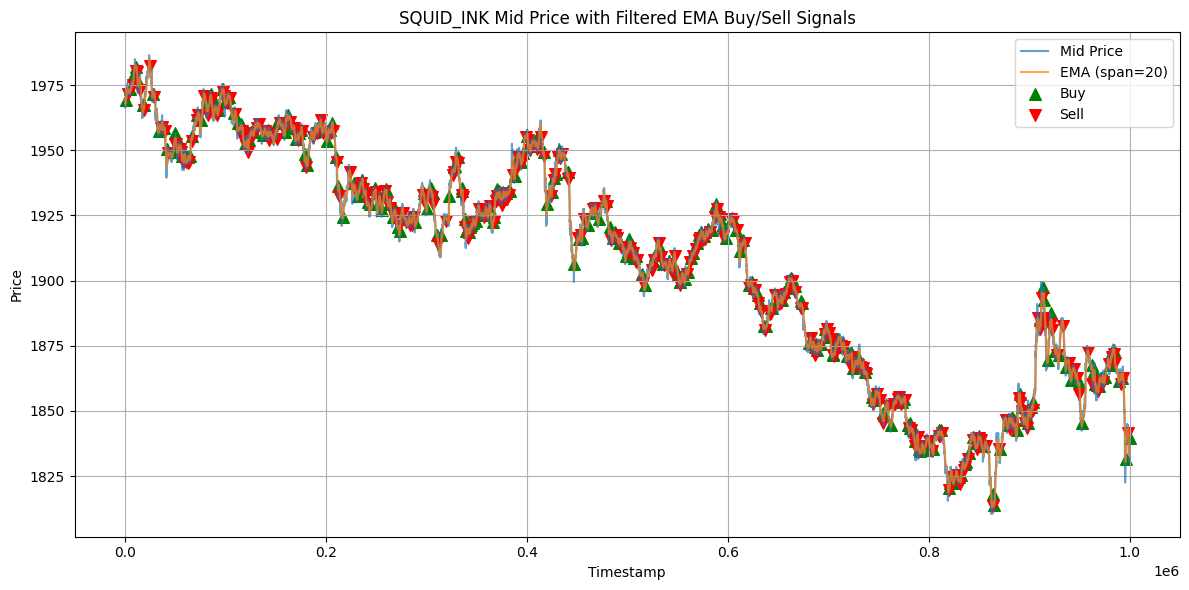

In [250]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load and filter data
market_data = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_0.csv"), sep=";")
market_data = market_data[market_data['product'] == "SQUID_INK"]
market_data = market_data[market_data['timestamp'] < 1e6].copy()

# Compute EMA
market_data['ema'] = market_data['mid_price'].ewm(span=8, adjust=False).mean()

# Basic signal: 1 if price > ema, else 0
market_data['raw_signal'] = (market_data['mid_price'] > market_data['ema']).astype(int)

# Confirmed signal: only change if stable for last N steps
N = 2
confirmed_signal = [market_data['raw_signal'].iloc[0]] * N  # initialize with first value repeated N times
final_signal = []

for i in range(len(market_data)):
    window = confirmed_signal[-N:]
    current = market_data['raw_signal'].iloc[i]
    if all(sig == current for sig in window):  # if stable in the last N
        final_signal.append(current)
    else:
        final_signal.append(final_signal[-1] if final_signal else current)  # keep previous confirmed signal
    confirmed_signal.append(current)

market_data['signal'] = final_signal

# Identify new confirmed signal changes (arrows only when signal changes)
market_data['signal_change'] = market_data['signal'].diff().fillna(0)
buy_signals = market_data[market_data['signal_change'] == 1]
sell_signals = market_data[market_data['signal_change'] == -1]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(market_data['timestamp'], market_data['mid_price'], label='Mid Price', alpha=0.7)
plt.plot(market_data['timestamp'], market_data['ema'], label='EMA (span=20)', alpha=0.7)

# Add filtered buy/sell markers
plt.scatter(buy_signals['timestamp'], buy_signals['mid_price'], marker='^', color='green', label='Buy', s=70)
plt.scatter(sell_signals['timestamp'], sell_signals['mid_price'], marker='v', color='red', label='Sell', s=70)

# Labeling
plt.title("SQUID_INK Mid Price with Filtered EMA Buy/Sell Signals")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ok... i think this signal is a decent starting point. day trading ahh strategy.  

we track the EMA over time. When the mid price > ema, buy. when the mid price < ema, sell signal.  

But this is just the raw signal. TO filter out oscillations we require that the previous x signals are consistent.  

so if the signals are like 'hmmm buy, actually no sell, actually buy... ' then dont, but if its like 'buy buy buy buy buy ' then buy  

To get to position, lets just cross the spread? to reduce complexity.  

the issue is that playing aroudn with a few values, this signal doesn't seem too strong. It catches that huge dip, but in oother parts it keeps selling lower than its buying.  



Lets look at order volumes as well, nathan/steven said there was a market making bot quoting huge volumes on both sides.  

<Figure size 1000x600 with 0 Axes>

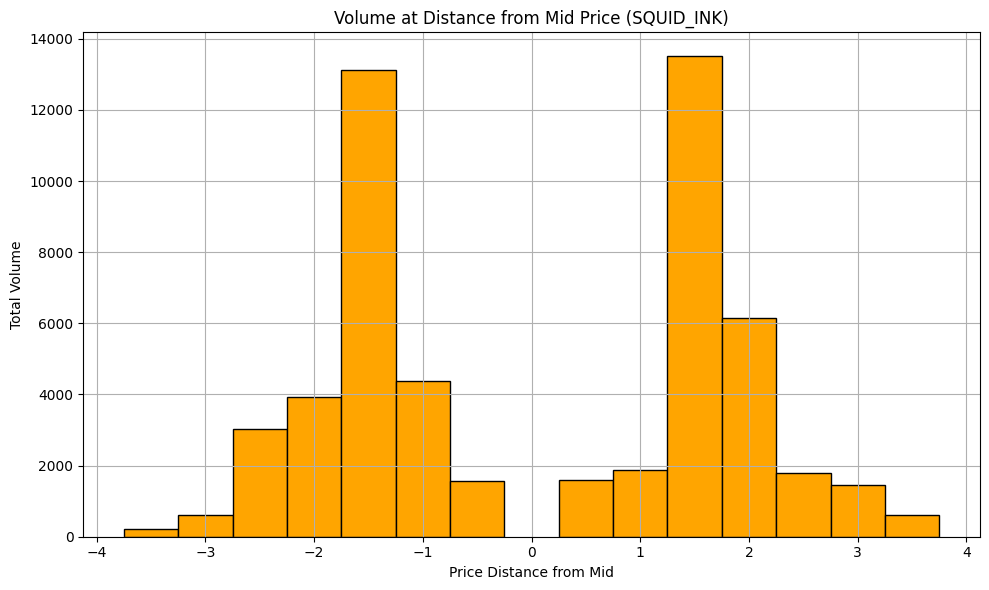

In [229]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Load and filter data
market_data = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_0.csv"), sep=";")
market_data = market_data[market_data['product'] == "SQUID_INK"]
market_data= market_data[market_data['timestamp'] < 1e5 ]


plt.figure(figsize=(10,6))

volume_at_dist_from_mid = defaultdict(int)


for _, row in market_data.iterrows():
    for side in ["bid", "ask"]:
        for i in range(1,4,1):
            if not pd.isna(row[f"{side}_price_{i}"]):
                dist =  row[f"{side}_price_{i}"] - row['mid_price']
                volume_at_dist_from_mid[dist] += row[f"{side}_volume_{i}"]
distances = sorted(volume_at_dist_from_mid.keys())
volumes = [volume_at_dist_from_mid[dist] for dist in distances]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(distances, volumes, width=0.5, color="orange", edgecolor="black")
plt.title("Volume at Distance from Mid Price (SQUID_INK)")
plt.xlabel("Price Distance from Mid")
plt.ylabel("Total Volume")
plt.grid(True)
plt.tight_layout()
plt.show()



I remember someone said somethign about mean reverting. Lets run the adf test.

In [230]:
market_data = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_-2.csv"), sep=";")
market_data = market_data[market_data['product'] == "SQUID_INK"]
mid_prices = market_data['mid_price'].dropna().reset_index(drop=True)
from statsmodels.tsa.stattools import adfuller

# Run ADF test on mid price series
adf_result = adfuller(mid_prices)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Used lag:", adf_result[2])
print("Number of observations:", adf_result[3])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

# for day -2 we get p-value 0.433
# for day -1 we get p value 0.057
# for day 0 we get p value 0.644

 

# ok so its probably not mean reverting.





ADF Statistic: -1.6934581455021633
p-value: 0.4344861500294848
Used lag: 32
Number of observations: 9967
Critical Values:
   1%: -3.4310062641674843
   5%: -2.8618300296182304
   10%: -2.56692437762918


so then is it just a random walk? 

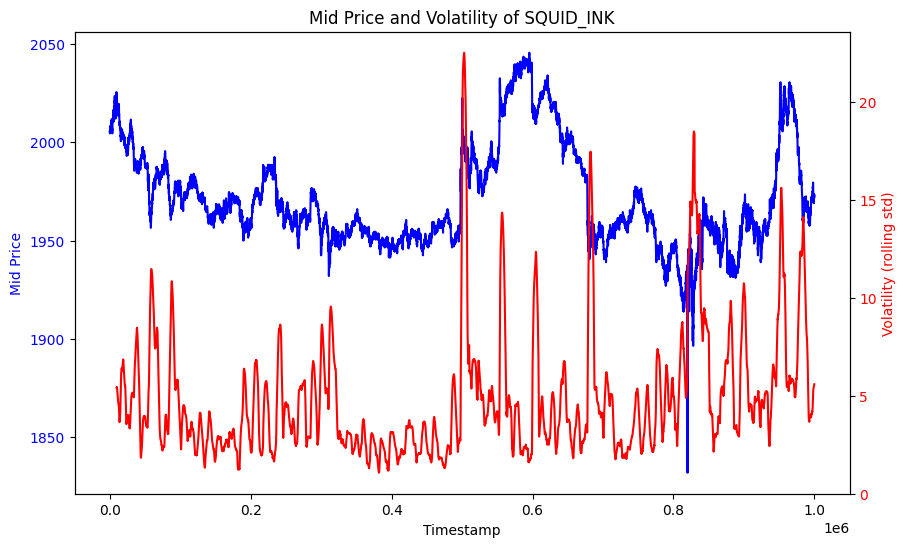

In [231]:

# Load and filter data
market_data = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_-1.csv"), sep=";")
market_data = market_data[market_data['product'] == "SQUID_INK"]

# Calculate rolling volatility
market_data['vol'] = market_data['mid_price'].rolling(window=100).std()

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot mid_price on left y-axis
ax1.plot(market_data['timestamp'], market_data['mid_price'], color='blue', label='Mid Price')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Mid Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for volatility
ax2 = ax1.twinx()
ax2.plot(market_data['timestamp'], market_data['vol'], color='red', label='Volatility')
ax2.set_ylabel('Volatility (rolling std)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Mid Price and Volatility of SQUID_INK")
plt.show()

looks like theres something to do with the volatility.  
sometimes when the volatility shoots up the price goes on an uptrend  
this happens more often than when the vol shoots up and the price goes down?  

but like i think these two happen at the same time because vol is just a function of movement of price  

but like even for a lot of timesteps after the shootup it starts to go up?  
idk  
not any strong signal yet...  

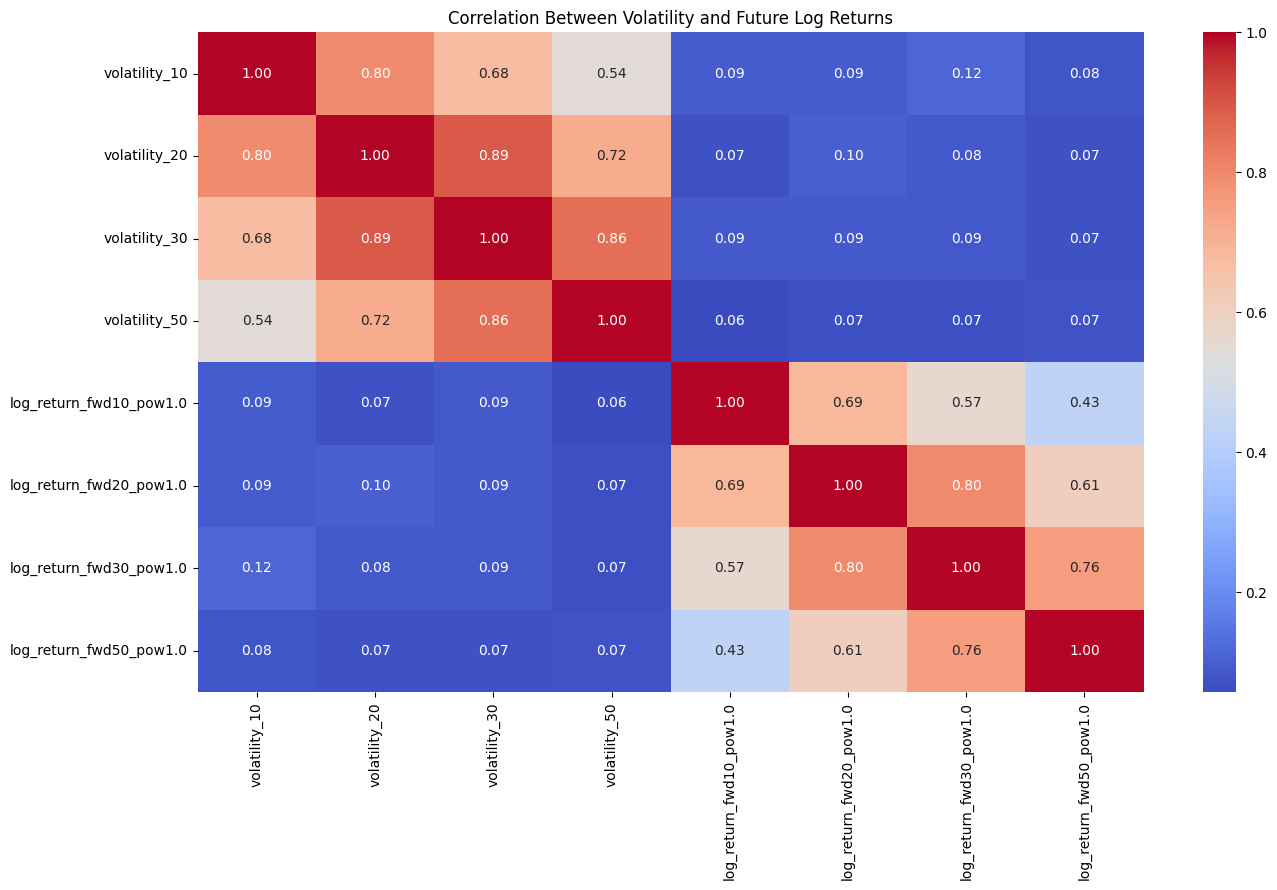

In [232]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load and filter data
market_data = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_-1.csv"), sep=";")
market_data = market_data[market_data["product"] == "SQUID_INK"].copy()

# Log prices
market_data["log_price"] = np.log(market_data["mid_price"])

# Rolling volatilities
features = []
for volwindow in [10, 20, 30, 50]:
    colname = f"volatility_{volwindow}"
    market_data[colname] = market_data["mid_price"].rolling(window=volwindow).std()
    features.append(colname)

# Forward (future) log returns
for lag in [10, 20, 30, 50]:
    for power in [1]:#np.linspace(1, 2, 5):
        ret_col = f"log_return_fwd{lag}_pow{power:.1f}"
        future_return = market_data["log_price"].shift(-lag) - market_data["log_price"]
        market_data[ret_col] = np.power(future_return, power)
        features.append(ret_col)

# Drop NaNs
feature_data = market_data[features].dropna()

# Correlation matrix
corr_matrix = feature_data.corr()

# Heatmap
plt.figure(figsize=(14, 9))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Volatility and Future Log Returns")
plt.tight_layout()
plt.show()


lowkey dont know what im doing ..  

In [233]:
import os
import pandas as pd
import numpy as np
from arch.unitroot import VarianceRatio

# Load market data
market_data = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_-1.csv"), sep=";")
market_data = market_data[market_data["product"] == "SQUID_INK"].copy()

# Compute log price
market_data["log_price"] = np.log(market_data["mid_price"])

# Option 1: Test log price (martingale with drift)
# series_to_test = market_data["log_price"].dropna()

# Option 2: Test log return (zero-mean martingale)
series_to_test = market_data["log_price"].diff(1).dropna()

# Run Variance Ratio test
vr_test = VarianceRatio(series_to_test, lags=2)  # try lags=2, 5, 10
print(vr_test.summary())


     Variance-Ratio Test Results     
Test Statistic                 -2.901
P-value                         0.004
Lags                                2
-------------------------------------

Computed with overlapping blocks (de-biased)


reject null hypothesis, so its not a martingale  (i think this was obvious anyways?)  

Lets try analyse things that happen at the huge dip

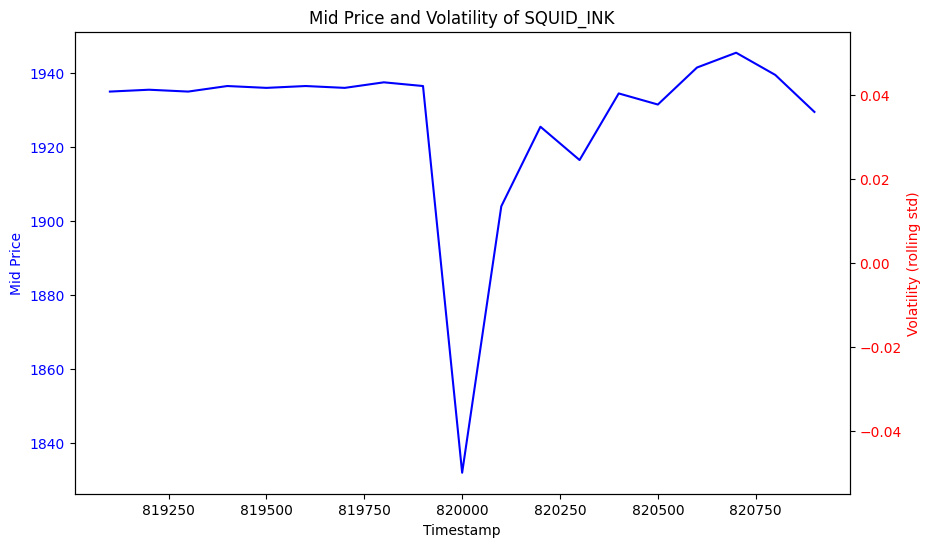

In [234]:

# Load and filter data
market_data = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_-1.csv"), sep=";")
market_data = market_data[market_data['product'] == "SQUID_INK"]
market_data = market_data[(market_data['timestamp'] > 819000 )& (market_data['timestamp'] < 821000)]

# Calculate rolling volatility
market_data['vol'] = market_data['mid_price'].rolling(window=100).std()

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot mid_price on left y-axis
ax1.plot(market_data['timestamp'], market_data['mid_price'], color='blue', label='Mid Price')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Mid Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for volatility
ax2 = ax1.twinx()
ax2.plot(market_data['timestamp'], market_data['vol'], color='red', label='Volatility')
ax2.set_ylabel('Volatility (rolling std)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Mid Price and Volatility of SQUID_INK")
plt.show()

zooming in on the dip, and looking at the csvs it seems that it only happens for literally one timestamp.  

so theres not too much ev to be gained from this dip. i was hoping it would give insight into what causes dips like this but it seems that time the dip happens for isn't long enoguh to make significant profit off.  

however what i do notice is that there is constnatly what seems to be a market maker quoting big sizes on either side of the orderbook. like, about 25-28 size, around the middle.  

this means theres good liquidity. whenever we want to take a direction, we can just buy from this marketmaker bot and reach position limits very quickly. we will pay the spread crossing but thats fine if we have a good signal to take a directional position.  



so what im thinking now is buying/selling pressure? if theres this market maker bot quoting roughly the same on both side constantly, we can probably assume that it is an informed market participant?  

maybe we can then just look at what trades are being placed with it, and based on that, we see what the retail flow wants to do. if the market maker's bots are getting hitted/lifted then maybe that'll give us an indication of where the price wants to go?  

looking at the csv it appears that the market maker is often at top level and then sometimes it gets pennied by the retail flow.  


MM Average quoting:  
Average mm bid quote size = 26.54726368159204  
Stddev mm bid quote size = 3.7759391405527953  
Average mm ask quote size = 26.105  
Stddev mm ask quote size = 3.3382592769286212  

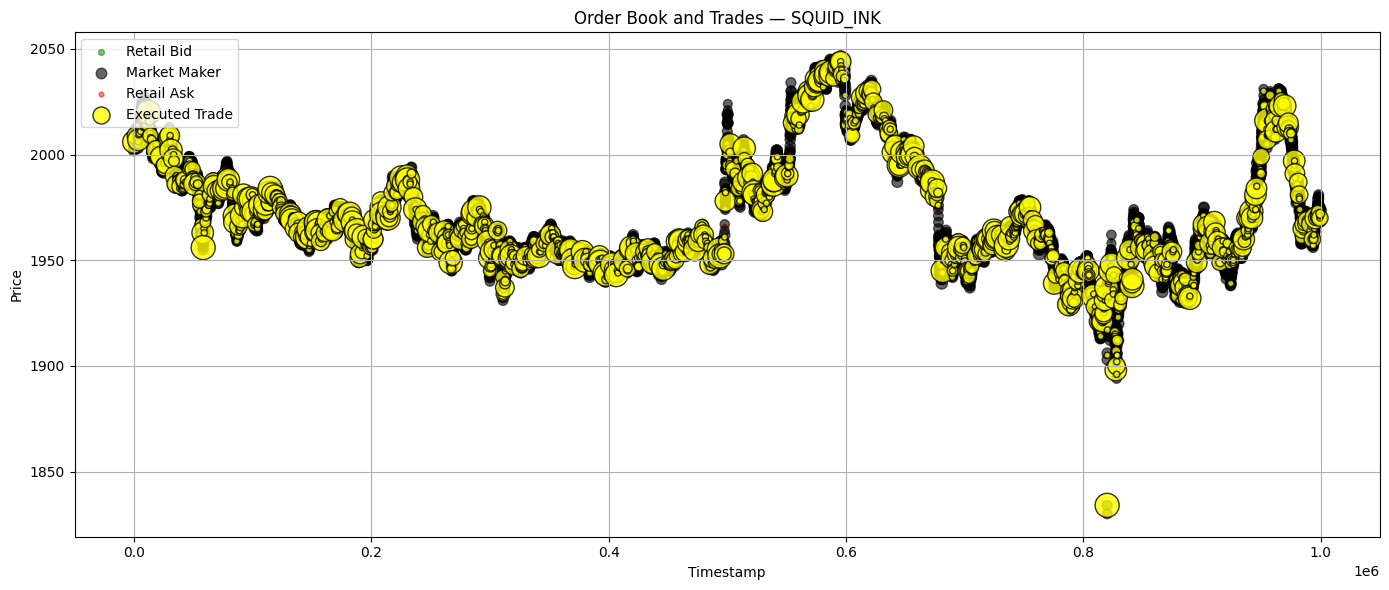

Average mm bid quote size = 26.201022658913175
Stddev mm bid quote size = 3.628971684810964
Average mm ask quote size = 25.875863449794775
Stddev mm ask quote size = 3.279029476157635


In [235]:

# Load and filter data
market_data = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_-1.csv"), sep=";")
market_data = market_data[market_data['product'] == "SQUID_INK"]

trade_history = pd.read_csv(os.path.join("..", "data", "round1", "trades_round_1_day_-1.csv"), sep=";")
trade_history = trade_history[trade_history['symbol'] == "SQUID_INK"]



#inclusive range.
timewindow = [0, 1e6]

market_data = market_data[(market_data['timestamp'] >= timewindow[0]) &(market_data['timestamp'] <= timewindow[1])]
trade_history = trade_history[(trade_history['timestamp'] >= timewindow[0]) &(trade_history['timestamp'] <= timewindow[1])]

# market maker activity
mmbid_sizes = []
mmbid_timestamps = []
mmask_sizes = []
mmask_timestamps = []


# Create plot
plt.figure(figsize=(14, 6))

# Plot bid quotes (green = retail, black = market maker)
for level in range(1, 4):
    price_col = f"bid_price_{level}"
    volume_col = f"bid_volume_{level}"
    
    is_mm = market_data[volume_col] >= 18
    is_retail = market_data[volume_col] < 18

    mmbid_sizes.extend(market_data[volume_col][is_mm].tolist())
    mmbid_timestamps.extend(market_data["timestamp"][is_mm].tolist())

    # Retail bids
    plt.scatter(
        market_data["timestamp"][is_retail],
        market_data[price_col][is_retail],
        s=market_data[volume_col][is_retail] * 2,
        c="green", alpha=0.5, label="Retail Bid" if level == 1 else ""
    )
    
    # Market maker bids
    plt.scatter(
        market_data["timestamp"][is_mm],
        market_data[price_col][is_mm],
        s=market_data[volume_col][is_mm] * 2,
        c="black", alpha=0.6, label="Market Maker" if level == 1 else ""
    )

# Plot ask quotes (red = retail, black = market maker)
for level in range(1, 4):
    price_col = f"ask_price_{level}"
    volume_col = f"ask_volume_{level}"
    
    is_mm = market_data[volume_col] >= 18
    is_retail = market_data[volume_col] < 18

    mmask_sizes.extend(market_data[volume_col][is_mm].tolist())
    mmask_timestamps.extend(market_data["timestamp"][is_mm].tolist())
 
    # Retail asks
    plt.scatter(
        market_data["timestamp"][is_retail],
        market_data[price_col][is_retail],
        s=market_data[volume_col][is_retail] * 2,
        c="red", alpha=0.5, label="Retail Ask" if level == 1 else ""
    )
    
    # Market maker asks
    plt.scatter(
        market_data["timestamp"][is_mm],
        market_data[price_col][is_mm],
        s=market_data[volume_col][is_mm] * 2,
        c="black", alpha=0.6, label=None  # label already used above
    )

# Plot executed trades (yellow)
plt.scatter(
    trade_history["timestamp"],
    trade_history["price"],
    s=trade_history["quantity"] *20,
    c="yellow", edgecolors="k", alpha=0.8,
    label="Executed Trade"
)

# Format plot
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.title("Order Book and Trades — SQUID_INK")
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

print(f"Average mm bid quote size = {np.mean(mmbid_sizes)}")
print(f"Stddev mm bid quote size = {np.std(mmbid_sizes)}")

print(f"Average mm ask quote size = {np.mean(mmask_sizes)}")
print(f"Stddev mm ask quote size = {np.std(mmask_sizes)}")


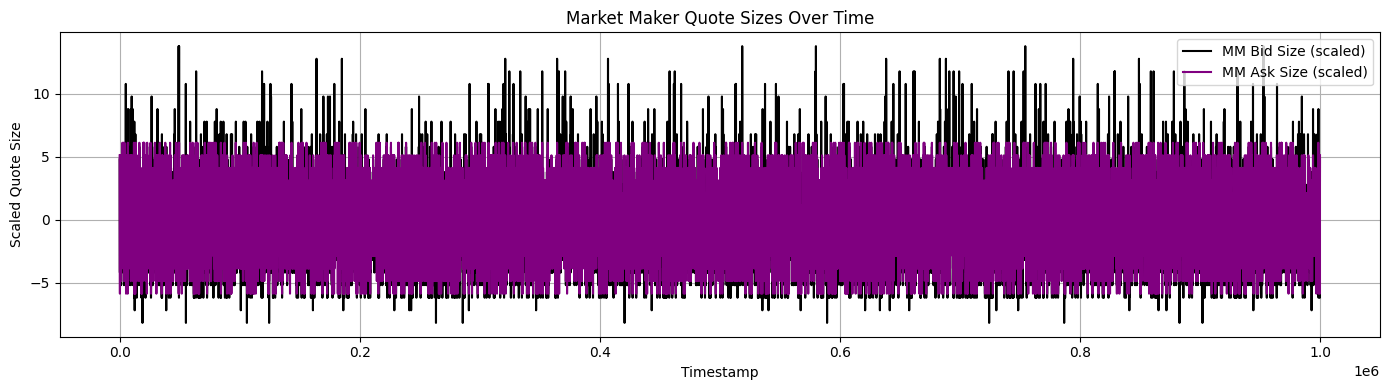

In [236]:
mmbid_size_avg = np.mean(mmbid_sizes)
mmbid_size_std = np.std(mmbid_sizes)

mmask_size_avg = np.mean(mmask_sizes)
mmask_size_std = np.std(mmask_sizes)

 

 

# Create Series with timestamp as index
mmbid_series = pd.Series(mmbid_sizes, index=mmbid_timestamps).sort_index()
mmask_series = pd.Series(mmask_sizes, index=mmask_timestamps).sort_index()

# Optional: reindex to uniform timestamps for line continuity
common_index = np.arange(
    min(min(mmbid_timestamps), min(mmask_timestamps)),
    max(max(mmbid_timestamps), max(mmask_timestamps)) + 1,
    100  # adjust step for smoothness vs performance
)

mmbid_series = mmbid_series.reindex(common_index).interpolate()
mmask_series = mmask_series.reindex(common_index).interpolate()

# Normalize
mmbid_size_scaled = mmbid_series - mmbid_series.mean()
mmask_size_scaled = mmask_series - mmask_series.mean()

diff = mmbid_size_scaled  - mmask_size_scaled

# Plot
plt.figure(figsize=(14, 4))
plt.plot(common_index, mmbid_size_scaled, color='black', label='MM Bid Size (scaled)')
plt.plot(common_index, mmask_size_scaled, color='purple', label='MM Ask Size (scaled)')

plt.xlabel("Timestamp")
plt.ylabel("Scaled Quote Size")
plt.title("Market Maker Quote Sizes Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


there was some model where the sizing is related to what they think the fair price is or somethign like that... maybe we can reverse engineer, and based on the sizes that the mm bot is quoting, we can determine what the mm bot thinks is going to happen to the price?  

although the quoting sizes seem pretty random ....  
lets try comparing lag returns with something to do with the mm bid and ask sizes?  



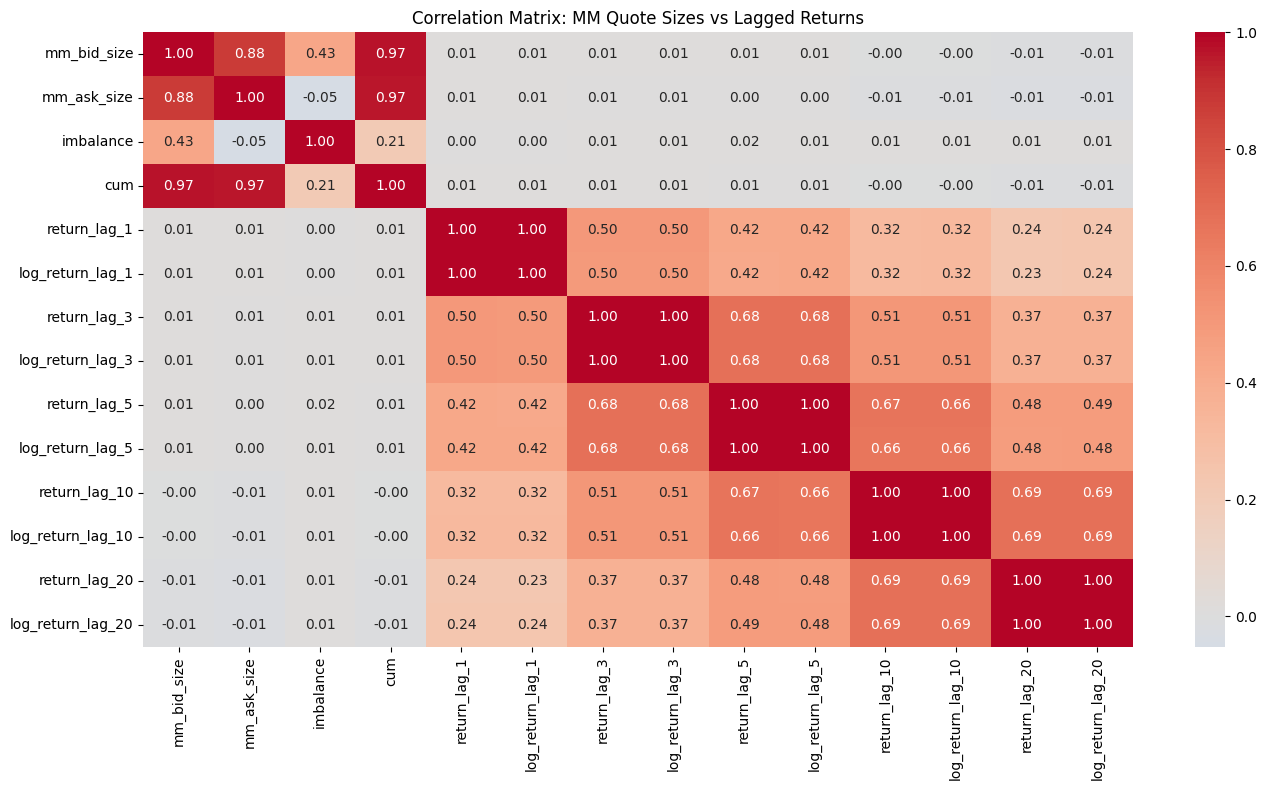

In [237]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Interpolate mid prices to common_index
mid_price = market_data["mid_price"].values
timestamps = market_data["timestamp"].values

mid_df = pd.DataFrame({"timestamp": timestamps, "mid_price": mid_price})
mid_df = mid_df.drop_duplicates("timestamp").sort_values("timestamp")

mid_interp = np.interp(common_index, mid_df["timestamp"], mid_df["mid_price"])
mid_log = np.log(mid_interp)

# Step 2: Compute lagged returns (raw and log)
lags = [1, 3, 5, 10, 20]
features = {
    "mm_bid_size": mmbid_series.values,
    "mm_ask_size": mmask_series.values,
    "imbalance": mmbid_series.values - mmask_series.values,
    "cum": mmbid_series.values + mmask_series.values,
}

for lag in lags:
    features[f"return_lag_{lag}"] = pd.Series(mid_interp).diff(lag).values
    features[f"log_return_lag_{lag}"] = pd.Series(mid_log).diff(lag).values

# Step 3: Create aligned DataFrame
features["timestamp"] = common_index
aligned_df = pd.DataFrame(features).dropna()

# Step 4: Seaborn correlation heatmap
plt.figure(figsize=(14, 8))
corr_matrix = aligned_df.drop(columns=["timestamp"]).corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix: MM Quote Sizes vs Lagged Returns")
plt.tight_layout()
plt.show()


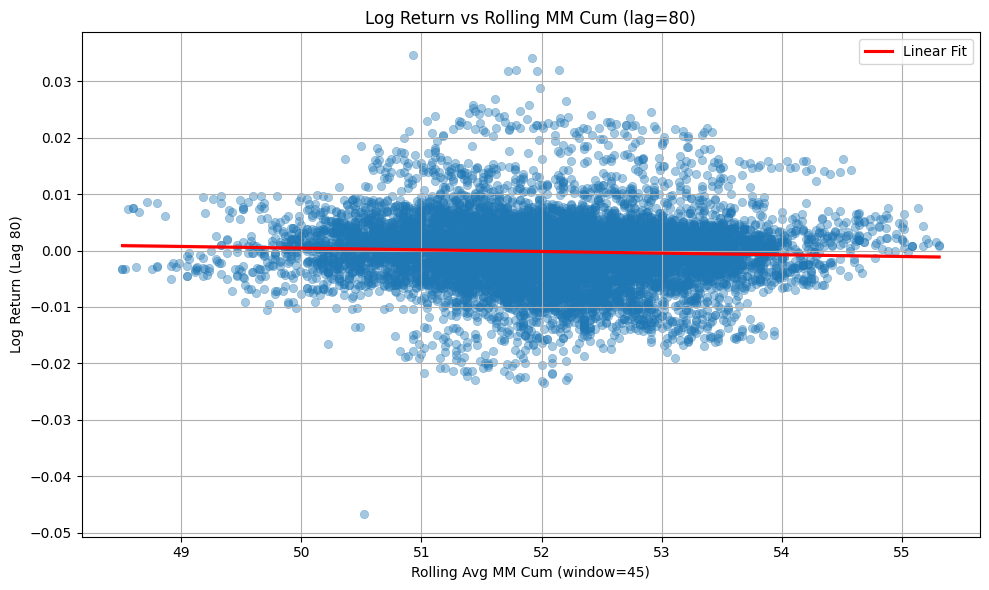

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Choose your lag and rolling window size
lag = 3
rolling_window = 3  # e.g., 10 timestamps wide

# Mid price interpolation (same as before)
mid_price = np.interp(aligned_df["timestamp"], mid_df["timestamp"], mid_df["mid_price"])
log_price = np.log(mid_price)
log_return = pd.Series(log_price).diff(lag).values

# Compute rolling average of MM cum size
# aligned_df["cum"] = aligned_df["mm_bid"] + aligned_df["mm_ask"]
rolling_cum = aligned_df["cum"].rolling(rolling_window).mean().values

# Align lengths
valid_idx = ~np.isnan(log_return) & ~np.isnan(rolling_cum)
x = rolling_cum[valid_idx]
y = log_return[valid_idx]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x, y=y, alpha=0.4, edgecolor=None)
sns.regplot(x=x, y=y, scatter=False, color="red", label="Linear Fit")

plt.xlabel(f"Rolling Avg MM Cum (window={rolling_window})")
plt.ylabel(f"Log Return (Lag {lag})")
plt.title(f"Log Return vs Rolling MM Cum (lag={lag})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


ok so by applying the time filter to 0...1e6, our previous observations is made redundant, turns out we were just overfitting  
(previously we were plotting log return 45 to rolling cum 80 but it displayed p = 0.85 just because the timeframe we were doing it over was showing a uptrend)  

i think also something we observe is that the logreturns are normally distributed.  

i think maybethere is something to do with regime changes, because if we had a p=0.85 fit in that small section of 2e4 timestamps then maybe we can just figure out what each regime is and fit really tightly to each regime..?  

actualyl  lets also plot the rolling cum maybe were jus tlooking at something useless  

based on how the MM is quoting, his imbalance doesn't really say anything because he's usually just quoting same amount on both sides. the amount he does quote does change but thats probably because of some np.rand() in the MM bot code, so we're probably trying to fit to the noise lol  




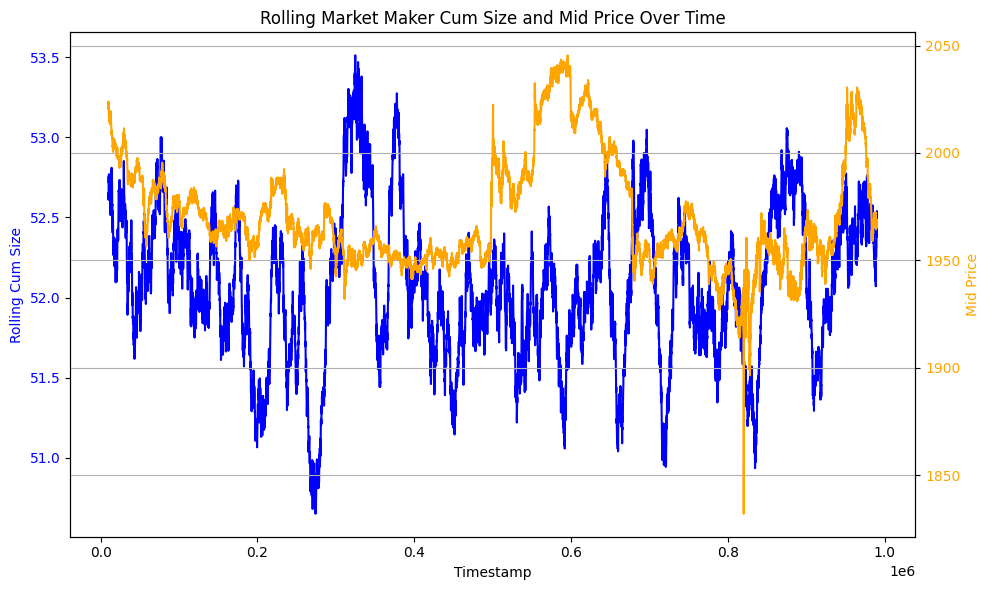

In [ ]:
# Recompute cum and rolling average
cum = mmbid_series.values + mmask_series.values
rolling_window = 100
rolling_cum = pd.Series(cum).rolling(rolling_window, center=True).mean()

# Interpolated mid price
mid_price = np.interp(common_index, mid_df["timestamp"], mid_df["mid_price"])

# Trim to valid values
valid = ~rolling_cum.isna()
x_vals = np.array(common_index)[valid]
cum_vals = rolling_cum[valid]
price_vals = mid_price[valid]

# Plot with twinx
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left axis: rolling cum
ax1.plot(x_vals, cum_vals, color='blue', label='Rolling Cum Size')
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Rolling Cum Size", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Right axis: mid price
ax2 = ax1.twinx()
ax2.plot(x_vals, price_vals, color='orange', label='Mid Price')
ax2.set_ylabel("Mid Price", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and layout
plt.title("Rolling Market Maker Cum Size and Mid Price Over Time")
fig.tight_layout()
plt.grid(True)
plt.show()


Best combination:
lag               65.000000
rolling_window    80.000000
correlation       -0.097984
Name: 207, dtype: float64


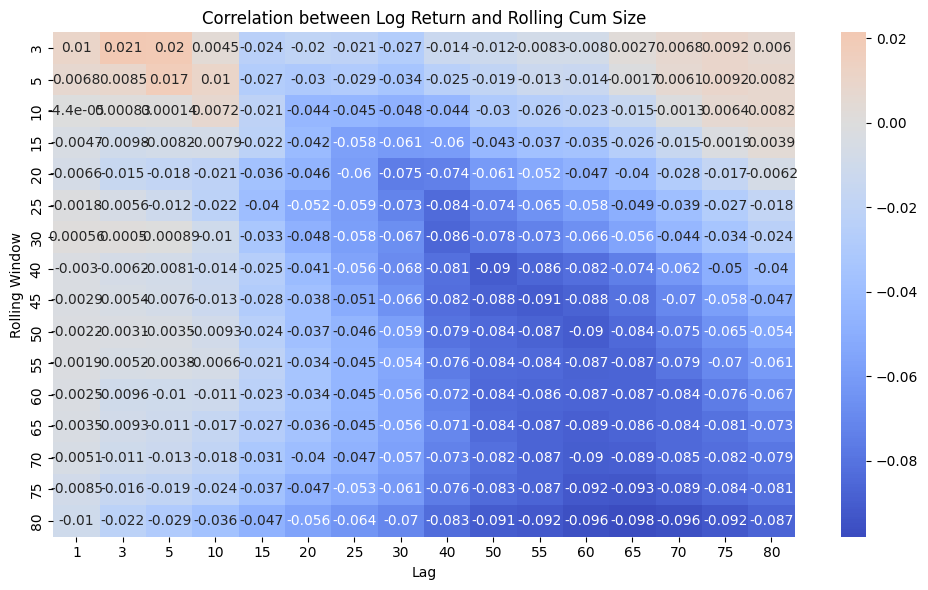

In [239]:
import numpy as np
import pandas as pd

# Recompute cum and mid_price
cum = mmbid_series.values + mmask_series.values
timestamps = common_index

mid_df = pd.DataFrame({"timestamp": market_data["timestamp"], "mid_price": market_data["mid_price"]})
mid_df = mid_df.drop_duplicates("timestamp").sort_values("timestamp")
mid_price_interp = np.interp(timestamps, mid_df["timestamp"], mid_df["mid_price"])
log_price = np.log(mid_price_interp)

# Parameter grid
lags = [1, 3, 5, 10, 15, 20, 25, 30, 40, 50,55,60,65,70,75,80]
windows = [3, 5, 10, 15, 20, 25, 30, 40,45,50,55,60,65,70,75,80]

results = []

# Grid search
for lag in lags:
    log_return = pd.Series(log_price).diff(lag).values

    for window in windows:
        rolling_cum = pd.Series(cum).rolling(window).mean().values

        # Remove NaNs introduced by rolling/lag
        valid = ~np.isnan(log_return) & ~np.isnan(rolling_cum)
        if np.sum(valid) < 10:
            continue  # not enough data

        corr = np.corrcoef(rolling_cum[valid], log_return[valid])[0, 1]
        results.append((lag, window, corr))

# Find best
results_df = pd.DataFrame(results, columns=["lag", "rolling_window", "correlation"])
best = results_df.loc[results_df["correlation"].abs().idxmax()]
print("Best combination:")
print(best)

# Optional: Heatmap of results
import seaborn as sns
import matplotlib.pyplot as plt

pivot = results_df.pivot(index="rolling_window", columns="lag", values="correlation")
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation between Log Return and Rolling Cum Size")
plt.xlabel("Lag")
plt.ylabel("Rolling Window")
plt.tight_layout()
plt.show()


what im thinking is that the MM bot is probably using some sort of MM model, for example Avellaneda-Stoikov.  
Perhaps we can reverse engineer it to think what the fair price is?  

let Avellaneda-Stoikov model = ASM.  

In ASM:  
Assumptions:

The MM is trying to maximize utility of terminal wealth
- It models order arrival rate as exponentially decreasing in quote distance
- It takes into account inventory risk, volatility, and time to end

Core behavior:

- The MM places quotes symmetrically around its estimate of fair price 
- But it adjusts spread width and size based on:
- Current inventory
- Market volatility
- Time remaining
- Possibly private alpha (if it has predictive edge)   

but it seems like all we can estimate from this is the fair price at time t that the market maker thinks... we want to predict the price much further into the future, because we want to take directional bets.  


research suggests it isn't mean reverting... but the imc still gives the hint that it is mean reverting.   

lets try 

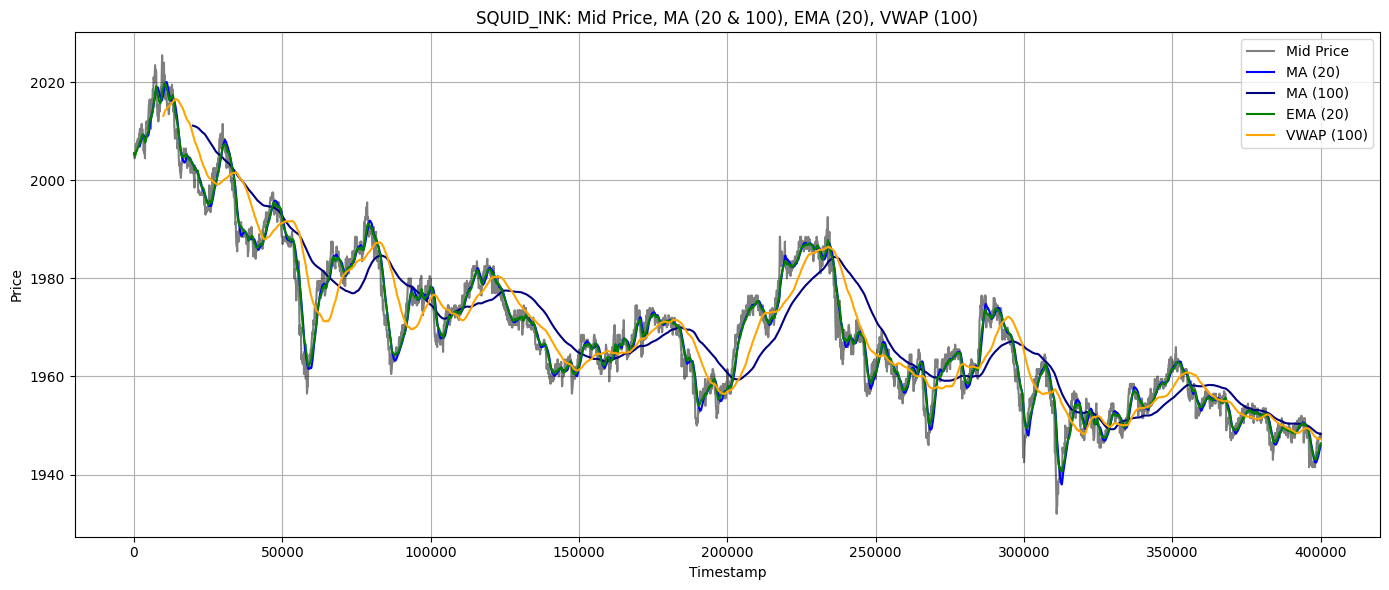

In [256]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load and filter data
market_data = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_-1.csv"), sep=";")
market_data = market_data[market_data['product'] == "SQUID_INK"]

trade_history = pd.read_csv(os.path.join("..", "data", "round1", "trades_round_1_day_-1.csv"), sep=";")
trade_history = trade_history[trade_history['symbol'] == "SQUID_INK"]

# Time window
timewindow = [0, 4e5]
market_data = market_data[(market_data['timestamp'] >= timewindow[0]) & (market_data['timestamp'] <= timewindow[1])]

# Mid price
market_data["mid_price"] = market_data[["bid_price_1", "ask_price_1"]].mean(axis=1)

# Moving averages
market_data["ma_20"] = market_data["mid_price"].rolling(20).mean()
market_data["ma_100"] = market_data["mid_price"].rolling(200).mean()

# Exponential moving average
market_data["ema_20"] = market_data["mid_price"].ewm(span=20).mean()

# VWAP with 100-period rolling
vwap_volume = market_data["bid_volume_1"] + market_data["ask_volume_1"]
market_data["vwap_numerator"] = market_data["mid_price"] * vwap_volume
market_data["vwap_denominator"] = vwap_volume

market_data["vwap_100"] = (
    market_data["vwap_numerator"].rolling(100).sum() /
    market_data["vwap_denominator"].rolling(100).sum()
)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(market_data["timestamp"], market_data["mid_price"], label="Mid Price", color="black", alpha=0.5)
plt.plot(market_data["timestamp"], market_data["ma_20"], label="MA (20)", color="blue")
plt.plot(market_data["timestamp"], market_data["ma_100"], label="MA (100)", color="navy")
plt.plot(market_data["timestamp"], market_data["ema_20"], label="EMA (20)", color="green")
plt.plot(market_data["timestamp"], market_data["vwap_100"], label="VWAP (100)", color="orange")

plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.title("SQUID_INK: Mid Price, MA (20 & 100), EMA (20), VWAP (100)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


so using the hint given by imc, it is short term mean reverting.  
but it isn't overall mean reverting. Therefore we have to keep track of some way to determine what the fair 'mean' is at some point.  

so i think the way this works is that within a short timeframe its mean reverting, but after its moved away, it will no longer revert because the mean has changed?  

wait isn't this just the principle of how 200ema and 20ema crossing works?  

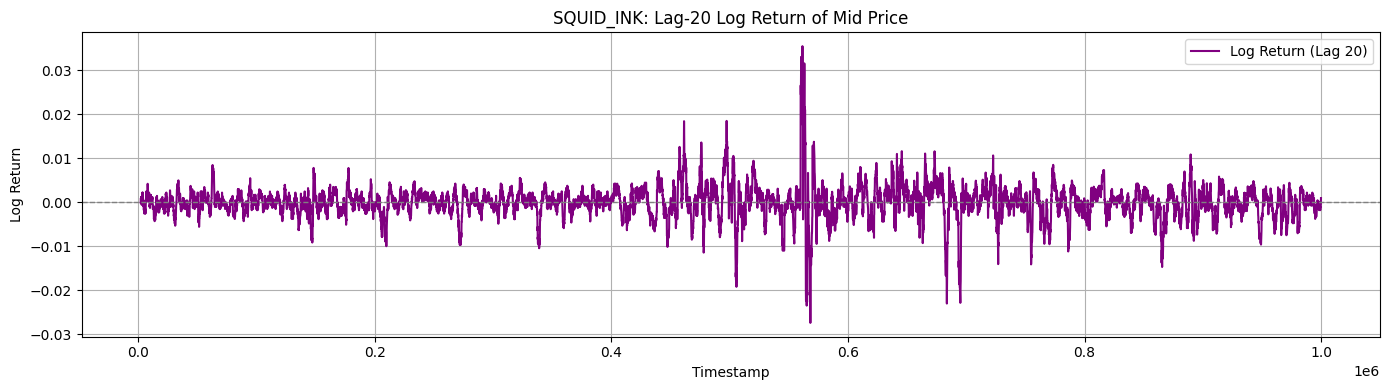

(1.5027375433088214e-06, 0.0038604307909341586)

In [276]:
import numpy as np
# Load and filter data
market_data = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_-2.csv"), sep=";")
market_data = market_data[market_data['product'] == "SQUID_INK"]

trade_history = pd.read_csv(os.path.join("..", "data", "round1", "trades_round_1_day_-2.csv"), sep=";")
trade_history = trade_history[trade_history['symbol'] == "SQUID_INK"]

# Time window
timewindow = [0, 1e6]
market_data = market_data[(market_data['timestamp'] >= timewindow[0]) & (market_data['timestamp'] <= timewindow[1])]


# Set your lag value here
lag = 20  # 🔁 change this to whatever lag you want

# Compute lag-x log return
market_data[f"log_return_lag{lag}"] = np.log(market_data["mid_price"] / market_data["mid_price"].shift(lag))
plt.figure(figsize=(14, 4))
plt.plot(market_data["timestamp"], market_data[f"log_return_lag{lag}"], label=f"Log Return (Lag {lag})", color="purple")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Timestamp")
plt.ylabel("Log Return")
plt.title(f"SQUID_INK: Lag-{lag} Log Return of Mid Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


np.mean(market_data[f"log_return_lag{lag}"]),np.std(market_data[f"log_return_lag{lag}"])

ok im pretty sure that this price action is just a martingale then??  
log returns are normally distributed 